### 0. Install libraries

In [1]:
# Install required packages.
!pip install -q torch-scatter -f https://pytorch-geometric.com/whl/torch-1.9.0+cu102.html
!pip install -q torch-sparse -f https://pytorch-geometric.com/whl/torch-1.9.0+cu102.html
!pip install -q torch-geometric

     |████████████████████████████████| 3.0 MB 7.6 MB/s 
     |████████████████████████████████| 1.6 MB 6.5 MB/s 
     |████████████████████████████████| 222 kB 27.2 MB/s 
     |████████████████████████████████| 376 kB 45.2 MB/s 
     |████████████████████████████████| 45 kB 2.5 MB/s 


In [2]:
%matplotlib inline

import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

import torch
from torch.nn import Linear
import torch.nn.functional as F

from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures
from torch_geometric.nn import GCNConv

from IPython.display import Javascript
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))

<IPython.core.display.Javascript object>

### 1. Load dataset


#### Node Classification with Graph Neural Networks

[Previous: Introduction: Hands-on Graph Neural Networks](https://colab.research.google.com/drive/1h3-vJGRVloF5zStxL5I0rSy4ZUPNsjy8)

This tutorial will teach you how to apply **Graph Neural Networks (GNNs) to the task of node classification**.
Here, we are given the ground-truth labels of only a small subset of nodes, and want to infer the labels for all the remaining nodes (*transductive learning*).

To demonstrate, we make use of the `Cora` dataset, which is a **citation network** where nodes represent documents.
Each node is described by a 1433-dimensional bag-of-words feature vector.
Two documents are connected if there exists a citation link between them.
The task is to infer the category of each document (7 in total).

This dataset was first introduced by [Yang et al. (2016)](https://arxiv.org/abs/1603.08861) as one of the datasets of the `Planetoid` benchmark suite.
We again can make use [PyTorch Geometric](https://github.com/rusty1s/pytorch_geometric) for an easy access to this dataset via [`torch_geometric.datasets.Planetoid`](https://pytorch-geometric.readthedocs.io/en/latest/modules/datasets.html#torch_geometric.datasets.Planetoid)

Overall, this dataset is quite similar to the previously used [`KarateClub`](https://pytorch-geometric.readthedocs.io/en/latest/modules/datasets.html#torch_geometric.datasets.KarateClub) network.
We can see that the `Cora` network holds 2,708 nodes and 10,556 edges, resulting in an average node degree of 3.9.
For training this dataset, we are given the ground-truth categories of 140 nodes (20 for each class).
This results in a training node label rate of only 5%.

In contrast to `KarateClub`, this graph holds the additional attributes `val_mask` and `test_mask`, which denotes which nodes should be used for validation and testing.
Furthermore, we make use of **[data transformations](https://pytorch-geometric.readthedocs.io/en/latest/notes/introduction.html#data-transforms) via `transform=NormalizeFeatures()`**.
Transforms can be used to modify your input data before inputting them into a neural network, *e.g.*, for normalization or data augmentation.
Here, we [row-normalize](https://pytorch-geometric.readthedocs.io/en/latest/modules/transforms.html#torch_geometric.transforms.NormalizeFeatures) the bag-of-words input feature vectors.

We can further see that this network is undirected, and that there exists no isolated nodes (each document has at least one citation).

In [4]:
dataset = Planetoid(root="data/Planetoid", name="Cora", transform=NormalizeFeatures())

print()
print(f"Dataset: {dataset}")
print(f"="*20)
print(f"Number of graphs: {len(dataset)}")
print(f"Number of features: {dataset.num_features}")
print(f"Number of classes: {dataset.num_classes}")

data = dataset[0] # Get the first graph object

print()
print(data)
print("="*30)

print(f"Number of nodes: {data.num_nodes}")
print(f"NUmber of edges: {data.num_edges}")
print(f"Average node degree: {data.num_edges/data.num_nodes:.2f}")
print(f"Number of training nodes: {data.train_mask.sum()}")
print(f"Training nodes label rate: {data.train_mask.sum() / data.num_nodes:.2f}")
print(f"Contains isolated nodes: {data.contains_isolated_nodes()}")
print(f"Contains self-loops: {data.contains_self_loops()}")
print(f"Is undirected: {data.is_undirected()}")

Processing...
Done!

Dataset: Cora()
Number of graphs: 1
Number of features: 1433
Number of classes: 7

Data(edge_index=[2, 10556], test_mask=[2708], train_mask=[2708], val_mask=[2708], x=[2708, 1433], y=[2708])
Number of nodes: 2708
NUmber of edges: 10556
Average node degree: 3.90
Number of training nodes: 140
Training nodes label rate: 0.05
Contains isolated nodes: False
Contains self-loops: False
Is undirected: True


### 2. Train baseline model: MLP

#### Training a Multi-layer Perception Network (MLP)

In theory, we should be able to infer the category of a document solely based on its content, *i.e.* its bag-of-words feature representation, without taking any relational information into account.

Let's verify that by constructing a simple MLP that solely operates on input node features (using shared weights across all nodes)

Our MLP is defined by two linear layers and enhanced by ReLU non-linearity and dropout. Here, we first reduce the 1433-dimensional feature vector to a low-dimensional embedding (hidden_channels=16), while the second linear layer acts as a classifier that should map each low-dimensional node embedding to one of the 7 classes.

Let's train our simple MLP by following a similar procedure as described in the first part of this tutorial. We again make use of the cross entropy loss and Adam optimizer. This time, we also define a test function to evaluate how well our final model performs on the test node set (which labels have not been observed during training).

In [6]:
class MLP(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(MLP, self).__init__()
        self.i2h = Linear(dataset.num_features, hidden_channels)
        self.h2o = Linear(hidden_channels, dataset.num_classes)

    def forward(self, x):
        x = self.i2h(x)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.h2o(x)
        return x    


model = MLP(hidden_channels=16)
print(model)

MLP(
  (i2h): Linear(in_features=1433, out_features=16, bias=True)
  (h2o): Linear(in_features=16, out_features=7, bias=True)
)


In [9]:
model = MLP(hidden_channels=16)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

def train():
    model.train()
    optimizer.zero_grad()
    
    out = model(data.x)
    loss = criterion(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss

def test():
    model.eval()
    out = model(data.x)
    pred = out.argmax(dim=1)
    test_correct = pred[data.test_mask] == data.y[data.test_mask]
    test_acc = int(test_correct.sum()) / int(data.test_mask.sum())
    return test_acc

for epoch in range(1, 200):
    loss = train() 
    print(f"Epoch: {epoch}, Loss: {loss}")

Epoch: 1, Loss: 1.9498502016067505
Epoch: 2, Loss: 1.947513222694397
Epoch: 3, Loss: 1.9436109066009521
Epoch: 4, Loss: 1.9371237754821777
Epoch: 5, Loss: 1.9319828748703003
Epoch: 6, Loss: 1.9263885021209717
Epoch: 7, Loss: 1.918514609336853
Epoch: 8, Loss: 1.9118636846542358
Epoch: 9, Loss: 1.8993700742721558
Epoch: 10, Loss: 1.8947304487228394
Epoch: 11, Loss: 1.8896089792251587
Epoch: 12, Loss: 1.8781312704086304
Epoch: 13, Loss: 1.867091178894043
Epoch: 14, Loss: 1.853455901145935
Epoch: 15, Loss: 1.8461240530014038
Epoch: 16, Loss: 1.836174488067627
Epoch: 17, Loss: 1.8178489208221436
Epoch: 18, Loss: 1.8190308809280396
Epoch: 19, Loss: 1.7854822874069214
Epoch: 20, Loss: 1.7831238508224487
Epoch: 21, Loss: 1.7490787506103516
Epoch: 22, Loss: 1.741363763809204
Epoch: 23, Loss: 1.7331733703613281
Epoch: 24, Loss: 1.7221349477767944
Epoch: 25, Loss: 1.7061328887939453
Epoch: 26, Loss: 1.6713000535964966
Epoch: 27, Loss: 1.673371434211731
Epoch: 28, Loss: 1.6437153816223145
Epoch: 2

In [10]:
test_acc = test()
print(f"Test accuracy: {test_acc}")

Test accuracy: 0.571


As one can see, our MLP performs rather bad with only about 59% test accuracy.
But why does the MLP do not perform better?
The main reason for that is that this model suffers from heavy overfitting due to only a **small amount of training nodes**, and therefore generalizes poorly to unseen node representations.

It also fails to incorporate an important bias into the model: **Cited papers are very likely related to the category of a document**.
That is exactly where Graph Neural Networks come into play and can help to boost the performance of our model.


### 3. Train GCN model

We can easily convert our MLP to a GNN by swapping the `torch.nn.Linear` layers with PyG's GNN operators.

Following-up on [the first part of this tutorial](https://colab.research.google.com/drive/1h3-vJGRVloF5zStxL5I0rSy4ZUPNsjy8), we replace the linear layers by the [`GCNConv`](https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#torch_geometric.nn.conv.GCNConv) module.
To recap, the **GCN layer** ([Kipf et al. (2017)](https://arxiv.org/abs/1609.02907)) is defined as

$$
\mathbf{x}_v^{(\ell + 1)} = \mathbf{W}^{(\ell + 1)} \sum_{w \in \mathcal{N}(v) \, \cup \, \{ v \}} \frac{1}{c_{w,v}} \cdot \mathbf{x}_w^{(\ell)}
$$

where $\mathbf{W}^{(\ell + 1)}$ denotes a trainable weight matrix of shape `[num_output_features, num_input_features]` and $c_{w,v}$ refers to a fixed normalization coefficient for each edge.
In contrast, a single linear layer is defined as

$$
\mathbf{x}_v^{(\ell + 1)} = \mathbf{W}^{(\ell + 1)} \mathbf{x}_v^{(\ell)}
$$

which does not make use of neighboring node information.

In [12]:
class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GCN, self).__init__()
        torch.manual_seed(12345) 
        self.conv1 = GCNConv(dataset.num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, dataset.num_classes)
    
    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return x

model = GCN(hidden_channels=16)
print(model)

GCN(
  (conv1): GCNConv(1433, 16)
  (conv2): GCNConv(16, 7)
)


In [15]:
def visualize(h, color):
    z = TSNE(n_components=2).fit_transform(out.detach().cpu().numpy())

    plt.figure(figsize=(10,10))
    plt.xticks([])
    plt.yticks([])

    plt.scatter(z[:, 0], z[:, 1], s=70, c=color, cmap="Set2")
    plt.show()

Let's visualize the node embeddings of our **untrained** GCN network.
For visualization, we make use of [**TSNE**](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html) to embed our 7-dimensional node embeddings onto a 2D plane

As one can see, there is at least *some kind* of clustering (*e.g.*, for the "blue" nodes), but we certainly can do better by training our model.
The training and testing procedure is once again the same, but this time we make use of the node features `x` **and** the graph connectivity `edge_index` as input to our GCN model.

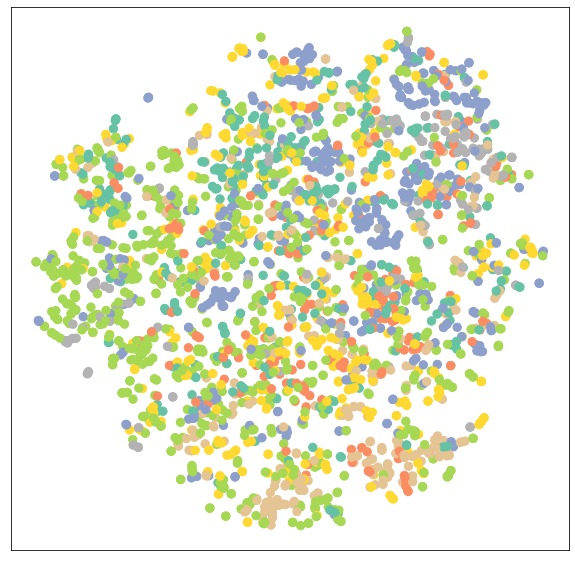

In [16]:
model = GCN(hidden_channels=16)
model.eval()

out = model(data.x, data.edge_index)
visualize(out, color=data.y)

In [18]:
model = GCN(hidden_channels=16)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

def train():
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = criterion(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()

    return loss

def test():
    model.eval()

    out = model(data.x, data.edge_index)
    pred = out.argmax(dim=1)
    test_correct = pred[data.test_mask] == data.y[data.test_mask]
    test_acc = int(test_correct.sum()) / int(data.test_mask.sum())

    return test_acc

for epoch in range(1, 201):
    loss = train()
    print(f"[EPOCH]- {epoch}: {loss:.4f} loss")

[EPOCH]- 1: 1.9451 loss
[EPOCH]- 2: 1.9384 loss
[EPOCH]- 3: 1.9307 loss
[EPOCH]- 4: 1.9227 loss
[EPOCH]- 5: 1.9126 loss
[EPOCH]- 6: 1.9076 loss
[EPOCH]- 7: 1.8917 loss
[EPOCH]- 8: 1.8809 loss
[EPOCH]- 9: 1.8728 loss
[EPOCH]- 10: 1.8616 loss
[EPOCH]- 11: 1.8453 loss
[EPOCH]- 12: 1.8397 loss
[EPOCH]- 13: 1.8237 loss
[EPOCH]- 14: 1.8057 loss
[EPOCH]- 15: 1.7979 loss
[EPOCH]- 16: 1.7808 loss
[EPOCH]- 17: 1.7667 loss
[EPOCH]- 18: 1.7555 loss
[EPOCH]- 19: 1.7436 loss
[EPOCH]- 20: 1.7184 loss
[EPOCH]- 21: 1.7126 loss
[EPOCH]- 22: 1.6845 loss
[EPOCH]- 23: 1.6717 loss
[EPOCH]- 24: 1.6673 loss
[EPOCH]- 25: 1.6353 loss
[EPOCH]- 26: 1.6181 loss
[EPOCH]- 27: 1.5962 loss
[EPOCH]- 28: 1.5723 loss
[EPOCH]- 29: 1.5708 loss
[EPOCH]- 30: 1.5370 loss
[EPOCH]- 31: 1.5162 loss
[EPOCH]- 32: 1.4948 loss
[EPOCH]- 33: 1.4713 loss
[EPOCH]- 34: 1.4589 loss
[EPOCH]- 35: 1.4479 loss
[EPOCH]- 36: 1.4377 loss
[EPOCH]- 37: 1.4271 loss
[EPOCH]- 38: 1.3644 loss
[EPOCH]- 39: 1.3658 loss
[EPOCH]- 40: 1.3363 loss
[EPOCH]- 

In [19]:
test_acc = test()
print(f"Test accuracy: {test_acc}")

Test accuracy: 0.814


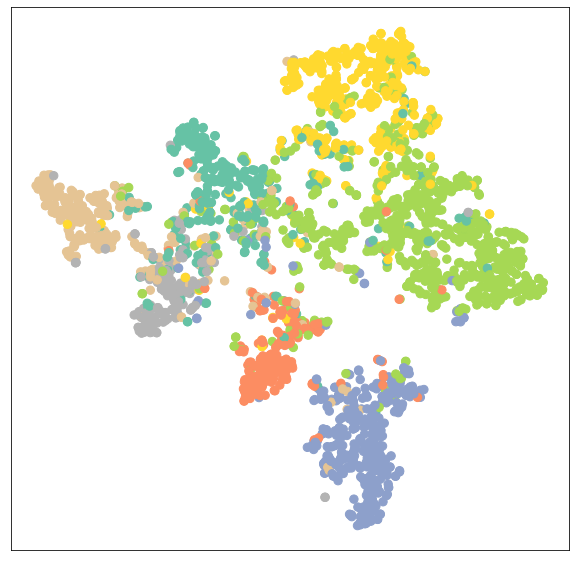

In [20]:
model.eval()

out = model(data.x, data.edge_index)
visualize(out, color=data.y)

**There it is!**
By simply swapping the linear layers with GNN layers, we can reach **81.4% of test accuracy**!
This is in stark contrast to the 59% of test accuracy obtained by our MLP, indicating that relational information plays a crucial role in obtaining better performance.

We can also verify that once again by looking at the output embeddings of our **trained** model, which now produces a far better clustering of nodes of the same category.

### 4. Extra

Early stopping with patience = 20 and Increase hidden channel size to 128

In [33]:
model = GCN(hidden_channels=128)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

patience = 20
current_loss = float('inf')
count = 0


def train():
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = criterion(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()

    return loss

def test():
    model.eval()

    out = model(data.x, data.edge_index)
    pred = out.argmax(dim=1)
    test_correct = pred[data.test_mask] == data.y[data.test_mask]
    test_acc = int(test_correct.sum()) / int(data.test_mask.sum())

    return test_acc

def valid():
    model.eval()

    out = model(data.x, data.edge_index)
    loss = criterion(out[data.val_mask], data.y[data.val_mask])
    pred = out.argmax(dim=1)
    val_correct = pred[data.val_mask] == data.y[data.val_mask] 
    val_acc = int(val_correct.sum()) / int(data.val_mask.sum()) 

    return loss, val_acc

for epoch in range(1, 501):
    loss = train()
    print(f"[EPOCH]- {epoch}: {loss:.4f} loss")

    val_loss, val_acc = valid()
    if val_loss < current_loss:
        current_loss = val_loss
        count = 0
    else:
        count += 1
    
    if count >= patience:
        break

print(f"Early stopping criteria met")
print(f"Val_loss: {val_loss:.4f} | Val_acc: {val_acc:.4f}")

[EPOCH]- 1: 1.9450 loss
[EPOCH]- 2: 1.9274 loss
[EPOCH]- 3: 1.9058 loss
[EPOCH]- 4: 1.8811 loss
[EPOCH]- 5: 1.8508 loss
[EPOCH]- 6: 1.8209 loss
[EPOCH]- 7: 1.7804 loss
[EPOCH]- 8: 1.7431 loss
[EPOCH]- 9: 1.7065 loss
[EPOCH]- 10: 1.6538 loss
[EPOCH]- 11: 1.6103 loss
[EPOCH]- 12: 1.5544 loss
[EPOCH]- 13: 1.5092 loss
[EPOCH]- 14: 1.4438 loss
[EPOCH]- 15: 1.3935 loss
[EPOCH]- 16: 1.3423 loss
[EPOCH]- 17: 1.2919 loss
[EPOCH]- 18: 1.2209 loss
[EPOCH]- 19: 1.1530 loss
[EPOCH]- 20: 1.1046 loss
[EPOCH]- 21: 1.0324 loss
[EPOCH]- 22: 0.9901 loss
[EPOCH]- 23: 0.9436 loss
[EPOCH]- 24: 0.8968 loss
[EPOCH]- 25: 0.8557 loss
[EPOCH]- 26: 0.7958 loss
[EPOCH]- 27: 0.7511 loss
[EPOCH]- 28: 0.7085 loss
[EPOCH]- 29: 0.6887 loss
[EPOCH]- 30: 0.6368 loss
[EPOCH]- 31: 0.6148 loss
[EPOCH]- 32: 0.5767 loss
[EPOCH]- 33: 0.5449 loss
[EPOCH]- 34: 0.5388 loss
[EPOCH]- 35: 0.5078 loss
[EPOCH]- 36: 0.4682 loss
[EPOCH]- 37: 0.4719 loss
[EPOCH]- 38: 0.4332 loss
[EPOCH]- 39: 0.4430 loss
[EPOCH]- 40: 0.4153 loss
[EPOCH]- 

In [34]:
test_acc = test()
print(f"test acc: {test_acc:.4f}")

test acc: 0.8070


## Conclusion

In this chapter, you have seen how to apply GNNs to real-world problems, and, in particular, how they can effectively be used for boosting a model's performance.
In the next section, we will look into how GNNs can be used for the task of graph classification.

[Next: Graph Classification with Graph Neural Networks](https://colab.research.google.com/drive/1I8a0DfQ3fI7Njc62__mVXUlcAleUclnb)

## (Optional) Exercises

1. To achieve better model performance and to avoid overfitting, it is usually a good idea to select the best model based on an additional validation set.
The `Cora` dataset provides a validation node set as `data.val_mask`, but we haven't used it yet.
Can you modify the code to select and test the model with the highest validation performance?
This should bring test performance to **82% accuracy**.

2. How does `GCN` behave when increasing the hidden feature dimensionality or the number of layers?
Does increasing the number of layers help at all?